<a href="https://colab.research.google.com/github/gayathrikarumuri/Phishing-URL-Detection/blob/main/phishingurl2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tldextract
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
X = pd.read_csv('/content/phishing_site_urls.csv')
X['URL'].str.strip()  # Remove unnecessary whitespaces
X


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
246344,thecia.com.au/reviews/s/savage-messiah.shtml,good
246345,thecia.com.au/reviews/s/seducing-doctor-lewis....,good
246346,thecinemaguy.com/films-about-unions-and-labor/,good
246347,thecityfix.com/blog/2011-sustainable-transport...,good


In [ ]:
special_df = pd.DataFrame()
special_chars = set()
def find_special_char(x):
    special_chars_in_x = re.findall(r'[^a-zA-Z0-9]', x)
    special_chars.update(special_chars_in_x)
    return None

X_bad = X[X['Label'] == 'bad']
X_bad['URL'].apply(find_special_char)

special_chars = list(special_chars)

special_chars.remove('.')
special_chars.remove('/')

special_df['Special Character'] = special_chars
special_df['Frequency in bad URLs'] = special_df['Special Character'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Bad probability'] = special_df['Frequency in bad URLs']/special_df['Special Character'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Score'] = special_df['Bad probability']*special_df['Frequency in bad URLs'].apply(math.log)

special_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
special_df

,Special Character,Frequency in bad URLs,Bad probability,Score
0,;,10234,0.926322,8.553163
1,\,3229,0.937028,7.571122
2,@,1773,0.962541,7.200217
3,',3585,0.817187,6.688279
4,&,15362,0.683667,6.590313
...,...,...,...,...
147,õ,1,0.030303,0.000000
148,Â,1,0.037037,0.000000
149,,1,0.041667,0.000000
150,±,1,0.041667,0.000000


[';', '\\', '@', "'", '&', '=', '?', ' ', '>', ',']


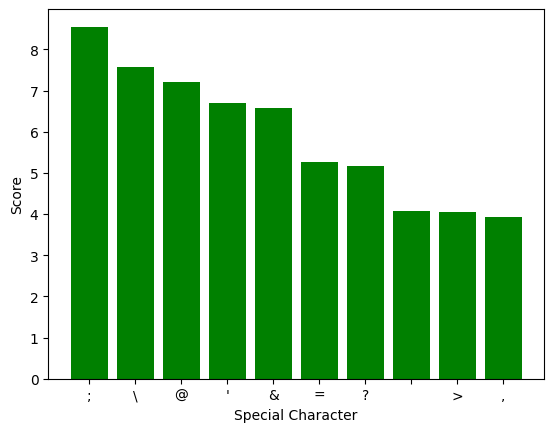

In [ ]:
dangerous_chars = list(special_df['Special Character'].head(10))
print(dangerous_chars)
plt.bar(special_df['Special Character'].head(10), special_df['Score'].head(10), color = 'green')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.show()

In [ ]:
TLD_df = pd.DataFrame()

TLD_list = pd.Series(X_bad['URL'].apply(lambda x: tldextract.extract(x).suffix)).unique()

TLD_df['TLD'] = TLD_list

TLD_df['Frequency in bad URLs'] = TLD_df['TLD'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Bad probability'] = TLD_df['Frequency in bad URLs']/TLD_df['TLD'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Score'] = TLD_df['Bad probability']*TLD_df['Frequency in bad URLs'].apply(math.log)

TLD_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
TLD_df

,TLD,Frequency in bad URLs,Bad probability,Score
0,md,8167,0.903929,8.142465
1,com.br,3781,0.984379,8.109063
2,cm,9922,0.864813,7.958450
3,date,4012,0.902790,7.490492
4,bf,3266,0.904208,7.316239
...,...,...,...,...
536,edu.ng,1,1.000000,0.000000
537,com.ba,1,1.000000,0.000000
538,ac.zm,1,1.000000,0.000000
539,sa.edu.au,1,1.000000,0.000000


['com.br', 'cm', 'bf', 'date', 'mx', 'run', 'com.cn', 'ae', 'md', 'com.ar']


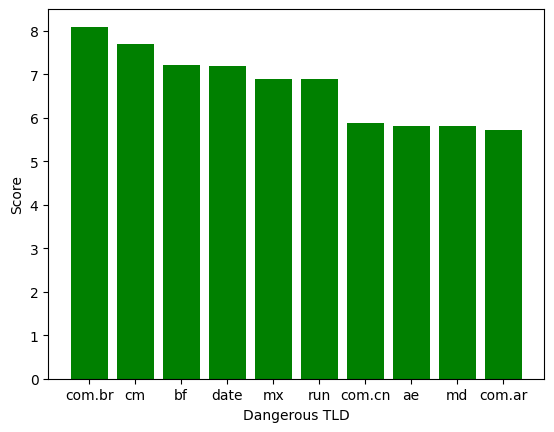

In [ ]:
dangerous_TLDs = list(TLD_df['TLD'].head(10))
print(dangerous_TLDs)
plt.bar(TLD_df['TLD'].head(10), TLD_df['Score'].head(10), color = 'green')
plt.xlabel('Dangerous TLD')
plt.ylabel('Score')
plt.show()

In [ ]:
#URL length

X['URL length'] = X['URL'].apply(len)

#2 Numbers of dots

X['Number of dots'] = X['URL'].apply(lambda x: x.count('.'))

#3 Number of slashes

X['Number of slashes'] = X['URL'].apply(lambda x: x.count('/'))

#4 Percentage of numerical characters

X['Percentage of numerical characters'] = X['URL'].apply(lambda x: sum(c.isdigit() for c in x))/X['URL length']

#5 Dangerous characters

X['Dangerous characters'] = X['URL'].apply(lambda x: any(char in x for char in dangerous_chars))

#6 Dangerous TLD

X['Dangerous TLD'] = X['URL'].apply(lambda x: tldextract.extract(x).suffix in dangerous_TLDs)
#7 Entropy

def urlentropy(url):
    frequencies = Counter(url)
    prob = [frequencies[char] / len(url) for char in url]
    return entropy(prob, base=2)


X['Entropy'] = X['URL'].apply(urlentropy)

#8 IP Address

ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'
X['IP Address'] = X['URL'].apply(lambda x: bool(re.search(ip_pattern, x)))

#9 Domain name length

X['Domain name length'] = X['URL'].apply(lambda x: len(tldextract.extract(x).domain))

#10 Suspicious keywords

sus_words = ['secure', 'account', 'update', 'login', 'verify' ,'signin', 'bank',
            'notify', 'click', 'inconvenient']

X['Suspicious keywords'] = X['URL'].apply(lambda x: sum([word in x for word in sus_words]) != 0)
#11 Repetitions

X['Repetitions'] = X['URL'].apply(lambda x: True if re.search(r'(.)\1{2,}', tldextract.extract(x).domain) else False)

#12 Redirections

def redirection(url):
  pos = url.rfind('//') #If the // is not found, it returns -1
  return pos>7

X['Redirections'] = X['URL'].apply(redirection)

#We print the new dataset

X


,URL,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,10,0.257778,True,False,7.667575,False,6,True,False,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,4,0.012346,True,True,6.190289,False,7,False,False,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,11,0.265537,False,True,7.288285,False,12,True,False,False
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,2,0.000000,False,True,5.786667,False,9,False,False,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,10,0.181034,True,True,6.611978,False,15,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321925,encyclopedia.com/topic/Waldo_David_Frank.aspx,good,45,2,2,0.000000,False,True,5.307909,False,12,False,False,False
321926,encyclopedia.com/topic/Walloons.aspx,good,36,2,2,0.000000,False,True,5.014279,False,12,False,False,False
321927,encyclopedia.com/topic/Walt_Disney.aspx,good,39,2,2,0.000000,False,True,5.187505,False,12,False,False,False
321928,encyclopedia.com/topic/Walt_Disney_Company.aspx,good,47,2,2,0.000000,False,True,5.453338,False,12,False,False,False


In [ ]:

scaler = StandardScaler()

num_columns = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length', 'Entropy']

X[num_columns] = scaler.fit_transform(X[num_columns])

In [ ]:
X['IP Address'] = X['IP Address'].astype(int)
X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
X['Repetitions'] = X['Repetitions'].astype(int)
X['Redirections'] = X['Redirections'].astype(int)
X['Dangerous characters'] = X['Dangerous characters'].astype(int)
X['Dangerous TLD'] = X['Dangerous TLD'].astype(int)
X['Label'] = (X['Label'] == 'good').astype(int)

X.drop(columns=['URL'], inplace=True)

X

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.673764,2.081949,4.256530,0.257778,1,0,2.855455,0,-0.754187,1,0,0
1,0,0.559128,1.511378,0.762342,0.012346,1,1,1.056228,0,-0.542839,0,0,0
2,0,2.635552,2.652520,4.838895,0.265537,0,1,2.393508,0,0.513903,1,0,0
3,0,0.104911,2.081949,-0.402388,0.000000,0,1,0.564647,0,-0.120142,0,0,0
4,0,1.316158,-0.770906,4.256530,0.181034,1,1,1.569815,0,1.147948,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321925,1,-0.219531,-0.200335,-0.402388,0.000000,0,1,-0.018446,0,0.513903,0,0,0
321926,1,-0.414195,-0.200335,-0.402388,0.000000,0,1,-0.376065,0,0.513903,0,0,0
321927,1,-0.349307,-0.200335,-0.402388,0.000000,0,1,-0.165089,0,0.513903,0,0,0
321928,1,-0.176272,-0.200335,-0.402388,0.000000,0,1,0.158676,0,0.513903,0,0,0


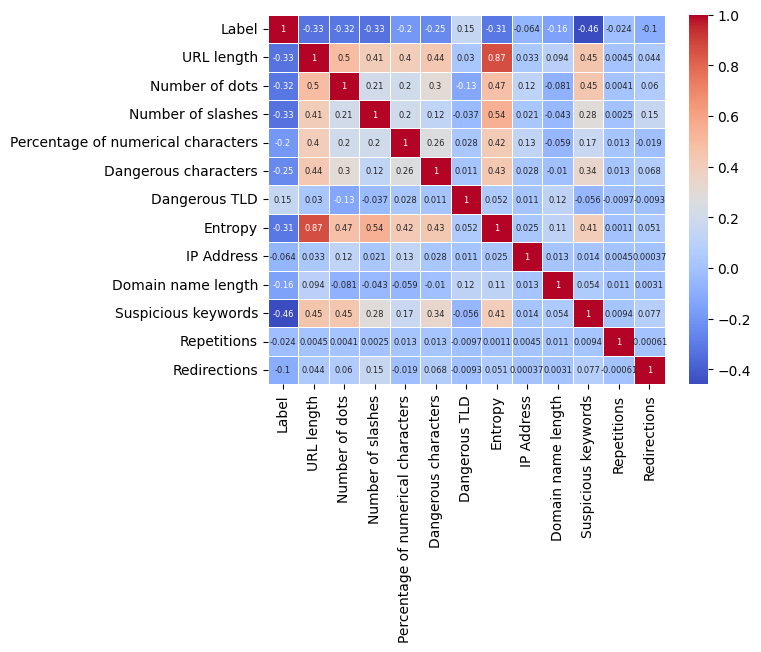

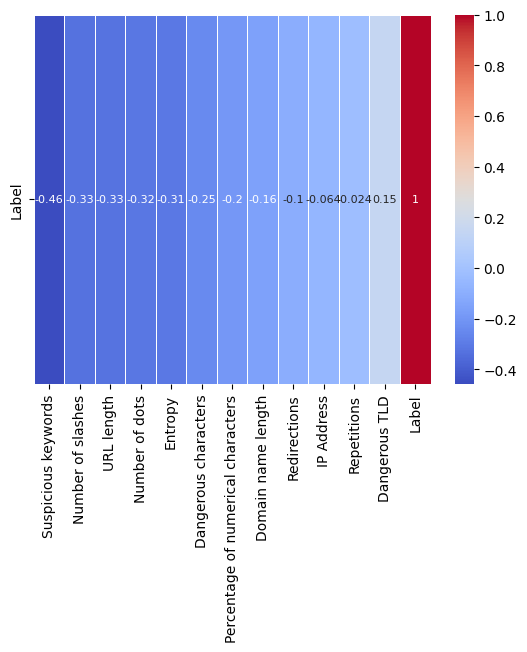

                                       Label
Suspicious keywords                -0.458612
Number of slashes                  -0.332658
URL length                         -0.325594
Number of dots                     -0.315512
Entropy                            -0.309497
Dangerous characters               -0.245217
Percentage of numerical characters -0.196412
Domain name length                 -0.155427
Redirections                       -0.104069
IP Address                         -0.063543
Repetitions                        -0.024118
Dangerous TLD                       0.150819
Label                               1.000000


In [ ]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label'))

In [ ]:
X['Label'].value_counts(normalize=True)

,proportion
Label,
1,0.718349
0,0.281651


In [ ]:
n_samples = X['Label'].value_counts()[0]
X_good = X[X['Label'] == 1]
X_bad = X[X['Label'] == 0]
X_goodsample = X_good.sample(n=n_samples, random_state=22)
X_goodmissing = X_good.drop(X_goodsample.index)

X = pd.concat([X_bad, X_goodsample], ignore_index=True)

X

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.673764,2.081949,4.256530,0.257778,1,0,2.855455,0,-0.754187,1,0,0
1,0,0.559128,1.511378,0.762342,0.012346,1,1,1.056228,0,-0.542839,0,0,0
2,0,2.635552,2.652520,4.838895,0.265537,0,1,2.393508,0,0.513903,1,0,0
3,0,0.104911,2.081949,-0.402388,0.000000,0,1,0.564647,0,-0.120142,0,0,0
4,0,1.316158,-0.770906,4.256530,0.181034,1,1,1.569815,0,1.147948,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181339,1,-0.695378,-0.770906,-0.984752,0.000000,0,1,-1.591096,0,1.781993,0,0,0
181340,1,-0.133013,0.370236,0.762342,0.000000,0,0,0.200724,0,-0.331491,0,0,0
181341,1,-0.803525,-0.770906,-0.984752,0.000000,0,1,-1.596539,0,0.725251,0,0,0
181342,1,-0.457454,-0.200335,-0.984752,0.000000,0,1,-0.521397,0,1.781993,0,0,0


In [ ]:
y = X['Label']
X.drop(columns=['Label'], inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

y_goodmissing = X_goodmissing['Label']
X_goodmissing.drop(columns=['Label'], inplace=True)

# Merging X_test and X_goodmissing

X_test = pd.concat([X_test, X_goodmissing], axis=0)

# Merging y_test and y_goodmissing

y_test = pd.concat([y_test, y_goodmissing], axis=0)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import classification_report

# Get prediction results
y_test_pred = rf_model.predict(X_test)

# Get the classification report to evaluate performance
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.43      0.87      0.58     18064
           1       0.98      0.87      0.92    158791

    accuracy                           0.87    176855
   macro avg       0.71      0.87      0.75    176855
weighted avg       0.93      0.87      0.89    176855



In [ ]:
from sklearn.metrics import accuracy_score
print(" Random forest accuracy:", accuracy_score(y_test, y_test_pred))

 Random forest accuracy: 0.868598569449549


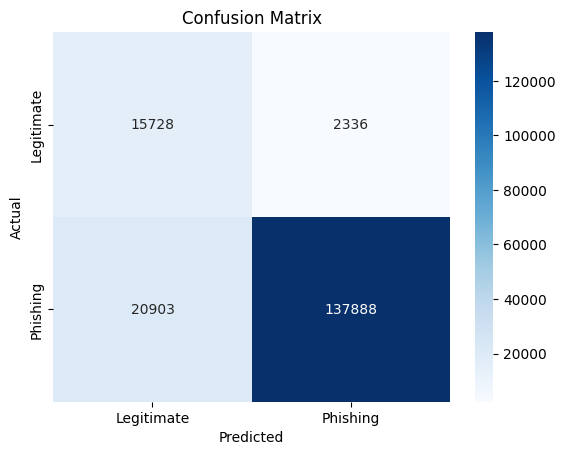

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Legitimate", "Phishing"], yticklabels=["Legitimate", "Phishing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Calculate scale_pos_weight = (number of negative samples) / (number of positive samples)
negative_class = (y_train == 0).sum()
positive_class = (y_train == 1).sum()
scale_pos_weight = negative_class / positive_class


In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


In [ ]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on train and test sets
x_train_pred = xgb_model.predict(X_train)
x_test_pred = xgb_model.predict(X_test)

# Accuracy
print("Train Accuracy:", accuracy_score(y_train, x_train_pred))
print("Test Accuracy:", accuracy_score(y_test, x_test_pred))

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, x_test_pred))

Train Accuracy: 0.8416818886782699
Test Accuracy: 0.8819032540781997

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.79      0.58     18064
           1       0.97      0.89      0.93    158791

    accuracy                           0.88    176855
   macro avg       0.71      0.84      0.75    176855
weighted avg       0.92      0.88      0.90    176855



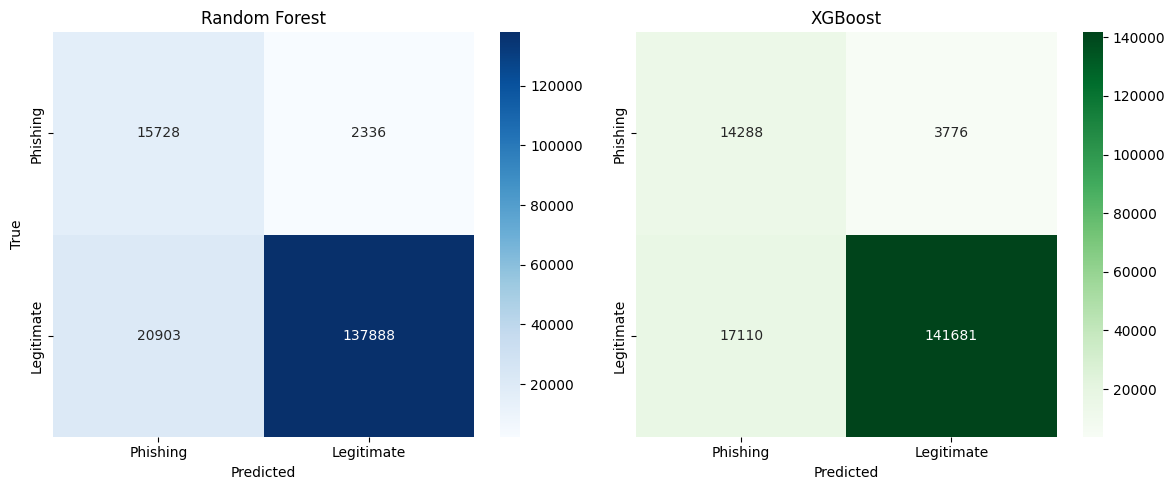

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Get confusion matrices
rf_cm = confusion_matrix(y_test, rf_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

# Labels
labels = ['Phishing', 'Legitimate']

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title('Random Forest')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title('XGBoost')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()


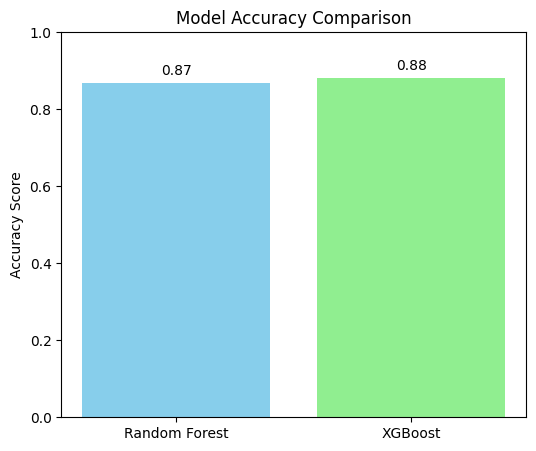

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Calculate accuracy scores
rf_acc = accuracy_score(y_test, rf_model.predict(X_test))
xgb_acc = accuracy_score(y_test, xgb_model.predict(X_test))

# Model names and scores
models = ['Random Forest', 'XGBoost']
accuracies = [rf_acc, xgb_acc]

# Plotting
plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.2f}', ha='center')

plt.show()
